Import package + model

In [304]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cobra
from cobra.io import (
    read_sbml_model,
    write_sbml_model
)
from cobra.flux_analysis import flux_variability_analysis
from tqdm import tqdm

In [305]:
M_xanthus = read_sbml_model("../M_xanthus_model.sbml") # import the Myxococcus xanthus model
M_xanthus

Name,myxo_model
Memory address,7c7966544050
Number of metabolites,1280
Number of reactions,1367
Number of genes,1192
Number of groups,0
Objective expression,1.0*OF_BIOMASS - 1.0*OF_BIOMASS_reverse_80d2e
Compartments,"c, e"


In [306]:
E_coli = read_sbml_model("../E_coli_model.sbml")
E_coli

Name,iML1515
Memory address,7c79368860d0
Number of metabolites,1877
Number of reactions,2714
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


**Adding Reactions**

In [307]:
Biomass_e = cobra.Metabolite(
    'Biomass_e',
    formula='BIOMASS',
    name='Biomass [e]',
    compartment='e')

M_xanthus.add_metabolites(Biomass_e) # add M_xanthus.metabolites.Biomass_e

M_xanthus.add_boundary(M_xanthus.metabolites.get_by_id("Biomass_e"), type="exchange") #add the exchange reaction for Biomass_e

Reaction identifier,EX_Biomass_e
Name,Biomass [e] exchange
Memory address,0x7c7966ac8260
Stoichiometry,Biomass_e <=> Biomass [e] <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [308]:
Mreaction = cobra.Reaction('PR_BIOMASS')
Mreaction.name = 'Predation Biomass'
Mreaction.subsystem = ''
Mreaction.lower_bound = 0.  # This is the default
Mreaction.upper_bound = 1000.  # This is the default

Biomass_e = M_xanthus.metabolites.Biomass_e

spmd_e = M_xanthus.metabolites.spmd_e # carbon source from exchange used in biomass reaction
pheme_e = M_xanthus.metabolites.pheme_e
val_L_e = M_xanthus.metabolites.val_L_e # imported AA
ile_L_e = M_xanthus.metabolites.ile_L_e
leu_L_e = M_xanthus.metabolites.leu_L_e
lys_L_e = M_xanthus.metabolites.lys_L_e
his_L_e = M_xanthus.metabolites.his_L_e
gly_cys_L_e = M_xanthus.metabolites.gly_cys_L_e
cgly_e = M_xanthus.metabolites.cgly_e
pro_L_e = M_xanthus.metabolites.pro_L_e
alaala_e = M_xanthus.metabolites.alaala_e
glu_L_c = M_xanthus.metabolites.glu_L_c
met_L_e = M_xanthus.metabolites.met_L_e
thr_L_e = M_xanthus.metabolites.thr_L_e
fru_e = M_xanthus.metabolites.fru_e # import fructose
malt_e = M_xanthus.metabolites.malt_e
gam_e = M_xanthus.metabolites.gam_e # from here test
fum_e = M_xanthus.metabolites.fum_e
orn_e = M_xanthus.metabolites.orn_e
succ_e = M_xanthus.metabolites.succ_e
acald_e = M_xanthus.metabolites.acald_e

Mreaction.add_metabolites({
    Biomass_e: -1,
    spmd_e: 1,
    pheme_e: 1,
    val_L_e: 1,
    ile_L_e: 1,
    leu_L_e: 1,
    lys_L_e: 1,
    his_L_e: 1,
    gly_cys_L_e: 1,
    cgly_e: 1,
    pro_L_e: 1,
    alaala_e: 1,
    fru_e: 1,
    malt_e: 1,
    glu_L_c: 1,
    met_L_e: 1,
    thr_L_e: 1,
    gam_e: 1,
    fum_e: 1,
    orn_e: 1,
    succ_e: 1,
    acald_e: 1
}) # add the metabolites to the reaction

Mreaction.gene_reaction_rule = '' # define which gene allow the reaction 

M_xanthus.add_reactions([Mreaction]) # add the PR_Biomass reaction

M_xanthus.reactions.PR_BIOMASS

Reaction identifier,PR_BIOMASS
Name,Predation Biomass
Memory address,0x7c78d20b89f0
Stoichiometry,Biomass_e --> acald_e + alaala_e + cgly_e + fru_e + fum_e + gam_e + glu_L_c + gly_cys_L_e + his_L_e + ile_L_e + leu_L_e + lys_L_e + malt_e + met_L_e + orn_e + pheme_e + pro_L_e + spmd_e + succ_e +... Biomass [e] --> Acetaldehyde [e] + Ala-Ala [e] + Cys-Gly [e] + D-Fructose [e] + Fumarate [e] + GLUM [e] + L-Glutamate [c] + Gly-Cys [e] + L-Histidine [e] + L-Isoleucine [e] + L-Leucine [e] +...
GPR,
Lower bound,0.0
Upper bound,1000.0


Change value

In [309]:
M_xanthus.reactions.EX_spmd_e.lower_bound = 0 # define the bound to 0 for metabolites in the reactions
M_xanthus.reactions.EX_pheme_e.lower_bound = 0
M_xanthus.reactions.EX_val_L_e.lower_bound = 0
M_xanthus.reactions.EX_ile_L_e.lower_bound = 0
M_xanthus.reactions.EX_leu_L_e.lower_bound = 0
M_xanthus.reactions.EX_lys_L_e.lower_bound = 0
M_xanthus.reactions.EX_gly_cys_L_e.lower_bound = 0
M_xanthus.reactions.EX_cgly_e.lower_bound = 0
M_xanthus.reactions.EX_pro_L_e.lower_bound = 0
M_xanthus.reactions.EX_alaala_e.lower_bound = 0
M_xanthus.reactions.EX_glu_L_e.lower_bound = 0
M_xanthus.reactions.EX_met_L_e.lower_bound = 0
M_xanthus.reactions.EX_thr_L_e.lower_bound = 0
M_xanthus.reactions.EX_fru_e.lower_bound = 0
M_xanthus.reactions.EX_malt_e.lower_bound = 0
M_xanthus.reactions.EX_gam_e.lower_bound = 0 # test
M_xanthus.reactions.EX_fum_e.lower_bound = 0
M_xanthus.reactions.EX_orn_e.lower_bound = 0
M_xanthus.reactions.EX_succ_e.lower_bound = 0
M_xanthus.reactions.EX_acald_e.lower_bound = 0

In [310]:
M_xanthus.reactions.EX_glc_D_e.id = 'EX_glc__D_e' # change the name to correspond to E_coli

**Dynamic environment**

In [ ]:
t = 0
tf = 50
steps = 0.5 
time_point = [0]
it = 1
y = [100, 100] # give the number of metabolites in the environment
biomass = 0 # quantities of Biomass in the environment
fluxes_E = []
fluxes_M = []
Biomass_E = [0]
Biomass_M = [0]

reactions_list_E_coli = [] # get all reaction of E_coli model
for reaction in E_coli.reactions:
    reactions_list_E_coli.append(reaction.id)

reactions_list_M_xanthus = []
for reaction in M_xanthus.reactions:
    reactions_list_M_xanthus.append(reaction.id)


def add_dynamic_bounds(model, y, biomass):
    """Use external concentrations to change the bound changing the uptake flux of the limited metabolites. \n
    :param sbml model: The model you want to add dynamic bounds. \n
    :param list(int) y: A list of the metabolite quantities in environment. In order: glucose, amonium. \n
    :param int biomass: Quantities of Biomass in the environment.
    """
    glucose, ammonium = y  # expand the boundary species (Can put more)

    glucose_max_import = -10 * glucose / (5 + glucose) # calculate the max import value for the metabolites
    ammonium_max_import = -10 * ammonium / (5 + ammonium)
    biomass_max_import = -10 * biomass / (5 + biomass)

    model.reactions.EX_nh4_e.lower_bound = ammonium_max_import

    E_coli.reactions.EX_glc__D_e.lower_bound = glucose_max_import  # change the limit of importation with the max import

    M_xanthus.reactions.EX_glc__D_e.bounds = [0,0]
    M_xanthus.reactions.EX_Biomass_e.lower_bound = biomass_max_import


def update_metabolites(fluxes, y, biomass):
    """Updtate the metabolites quantities depending of the fluxes. \n
    :param list(int) fluxes: The list of the fluxes. \n
    :param list(int) y: A list of the metabolite quantities in environment. In order: glucose, amonium, isoleucine. \n
    :param int biomass: Quantities of Biomass in the environment.
    """
    glucose, ammonium = y  # expand the boundary species (Can put more)

    glucose = glucose + fluxes["EX_glc__D_e"]  # calculate the number of metabolites
    ammonium = ammonium + fluxes["EX_nh4_e"]
    if "BIOMASS_Ec_iML1515_core_75p37M" in fluxes:
        biomass = biomass + fluxes["BIOMASS_Ec_iML1515_core_75p37M"]
    if "EX_Biomass_e" in fluxes:
        biomass = biomass + fluxes["EX_Biomass_e"]
    
    if glucose < 0:
        glucose = 0 #if the value goes below zero set the number of metaboltie to zero
    if ammonium < 0:
        ammonium = 0
    if biomass < 0:
        biomass = 0

    y = (glucose, ammonium)  # changing the value of the metabolites
    return y, biomass


with tqdm(total=tf) as pbar:
    while t < tf:
        add_dynamic_bounds(E_coli, y, biomass) ## For Escherichia coli
        FBA_1 = E_coli.optimize()  # perform flux balance analysis (FBA)
        fluxes_E_coli = FBA_1.fluxes.get(reactions_list_E_coli)  # store the fluxes of the FBA
        fluxes_E_coli *= 0.1  # multiply by Biomass Concentration to get flux
        fluxes_E.append(fluxes_E_coli)  # store all the fluxes
        y, biomass = update_metabolites(fluxes_E_coli, y, biomass)
        Biomass_E.append(Biomass_E[it - 1] + fluxes_E_coli["BIOMASS_Ec_iML1515_core_75p37M"])

        add_dynamic_bounds(M_xanthus, y, biomass) ## For Myxococcus xanthus
        FBA_2 = M_xanthus.optimize() 
        fluxes_M_xanthus = FBA_2.fluxes.get(reactions_list_M_xanthus) 
        fluxes_M_xanthus *= 0.1 
        fluxes_M.append(fluxes_M_xanthus) 
        y, biomass = update_metabolites(fluxes_M_xanthus, y, biomass)
        Biomass_M.append(Biomass_M[it - 1] + fluxes_M_xanthus["OF_BIOMASS"])

        time_point.append(time_point[it - 1] + steps) 
        it += 1
        t += steps
        pbar.update(steps)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


TypeError: list indices must be integers or slices, not str

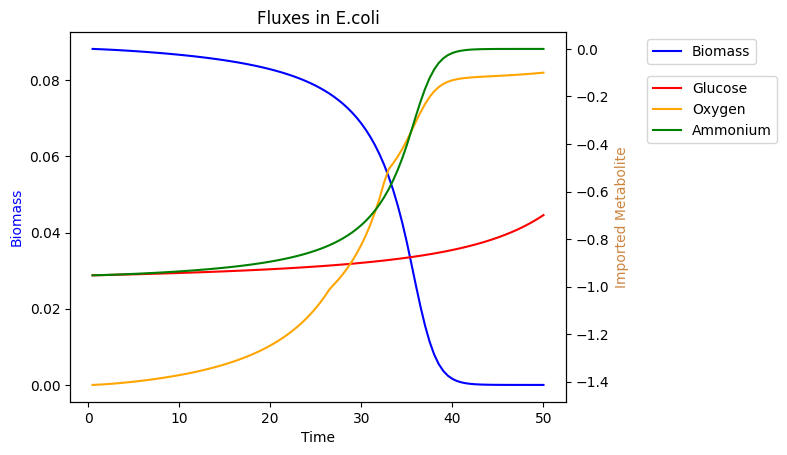

In [ ]:
glucose = []
oxygen = []
ammonium = []
biomass = []

for i in fluxes_E:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["BIOMASS_Ec_iML1515_core_75p37M"])
    oxygen.append(i["EX_o2_e"])
    ammonium.append(i["EX_nh4_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="blue", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], oxygen, color="orange", label="Oxygen")
ax2.plot(time_point[1:], ammonium, color="green", label="Ammonium")
ax.set_ylabel("Biomass", color="blue")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel('Time')

ax.set_title("Fluxes in E.coli")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

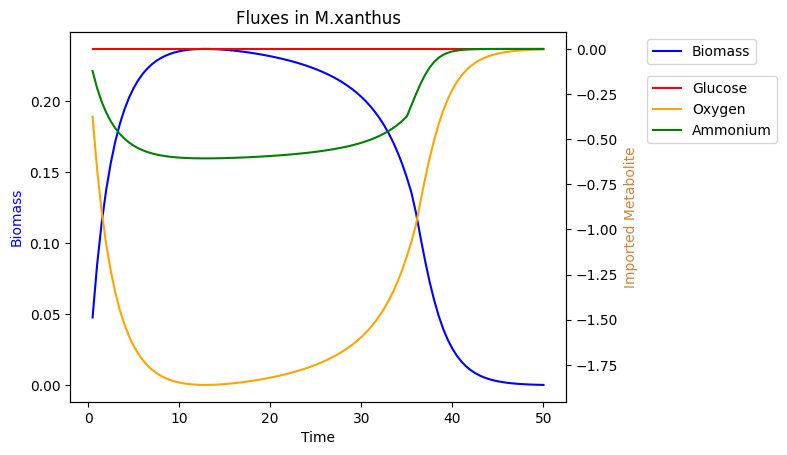

In [ ]:
glucose = []
oxygen = []
ammonium = []
biomass = []

for i in fluxes_M:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["OF_BIOMASS"])
    oxygen.append(i["EX_o2_e"])
    ammonium.append(i["EX_nh4_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="blue", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], oxygen, color="orange", label="Oxygen")
ax2.plot(time_point[1:], ammonium, color="green", label="Ammonium")

ax.set_ylabel("Biomass", color="blue")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel('Time')

ax.set_title("Fluxes in M.xanthus")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

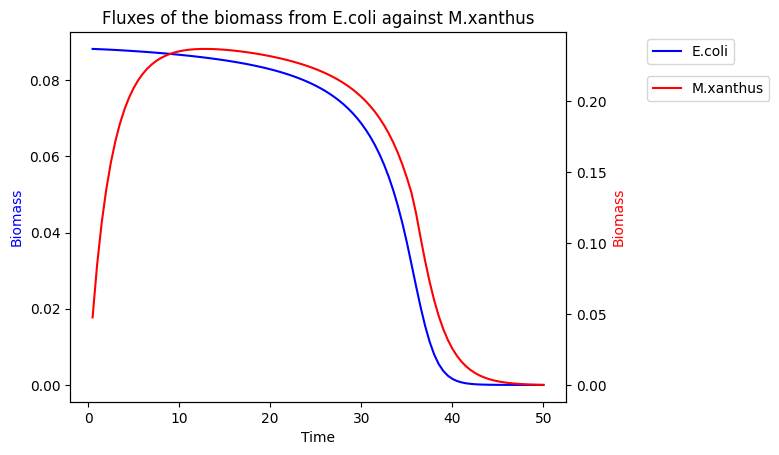

In [ ]:
biomass_E = []
biomass_M = []

for i in fluxes_M:
    biomass_M.append(i["OF_BIOMASS"]) # taking the biomass flux
for j in fluxes_E:
    biomass_E.append(j['BIOMASS_Ec_iML1515_core_75p37M'])


ax = plt.subplot(111)
ax.plot(time_point[1:], biomass_E, color="blue", label="E.coli") # plot the biomass flux of E_coli
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], biomass_M, color="red", label="M.xanthus")

ax.set_ylabel("Biomass", color="blue") # set the name
ax2.set_ylabel("Biomass", color="red")
ax.set_xlabel('Time')

ax.set_title("Fluxes of the biomass from E.coli against M.xanthus") # set the title
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left") # show the legend
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

In [ ]:
ax = plt.subplot(111)
ax.plot(time_point[1:], Biomass_E[1:], color="blue", label="E.coli") # plot the biomass flux of E_coli
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], Biomass_M[1:], color="red", label="M.xanthus")

ax.set_ylabel("Biomass", color="blue") # set the name
ax2.set_ylabel("Biomass", color="red")
ax.set_xlabel('Time')

ax.set_title("Fluxes of the biomass from E.coli against M.xanthus") # set the title
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left") # show the legend
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")